In [1]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt


In [2]:
def blur(image):
    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    gray = cv2.GaussianBlur(gray, (3, 3), 2)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 9)
    return threshold

In [3]:
def biggest_contour(contours, min_area):
    contour_subset = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        contour_subset.append(cv2.approxPolyDP(hull, 0.001 * cv2.arcLength(hull, True), True))
    contour_subset = np.array(contour_subset)
    
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contour_subset):
        area = cv2.contourArea(i)

        if area > min_area / 40:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour, contour_subset

In [4]:
def crop_image(image, contour_subset, biggest_n, approx_contour):
    threshold = cv2.drawContours(image, contour_subset, biggest_n, (0, 255, 0), 1)
    dst = 0
    if approx_contour is not None and len(approx_contour) == 4:
        approx_contour = np.float32(approx_contour)

        # Correctly order the poitns in the contour
        approx_contour = approx_contour.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        s = approx_contour.sum(axis=1)
        rect[0] = approx_contour[np.argmin(s)]
        rect[2] = approx_contour[np.argmax(s)]

        diff = np.diff(approx_contour, axis=1)
        rect[1] = approx_contour[np.argmin(diff)]
        rect[3] = approx_contour[np.argmax(diff)]

        
        # Crop based on points with a bit of padding
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")

        # Remove shear effect
        M = cv2.getPerspectiveTransform(rect, dst)
        dst = cv2.warpPerspective(threshold, M, (maxWidth, maxHeight))
        
        

    return dst

In [5]:
def sharpen_image(cropped_image):
    #Sharpen using filter
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened = cv2.filter2D(cropped_image, -1, kernel_sharpening)
    
    #Increase brightness
    increase_value = 30
    hsv = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - increase_value
    v[v > lim] = 255
    v[v <= lim] += increase_value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
    return img
    


C:\Users\user\AppData\Local\Temp\ipykernel_33588\3375695609.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contour_subset = np.array(contour_subset)


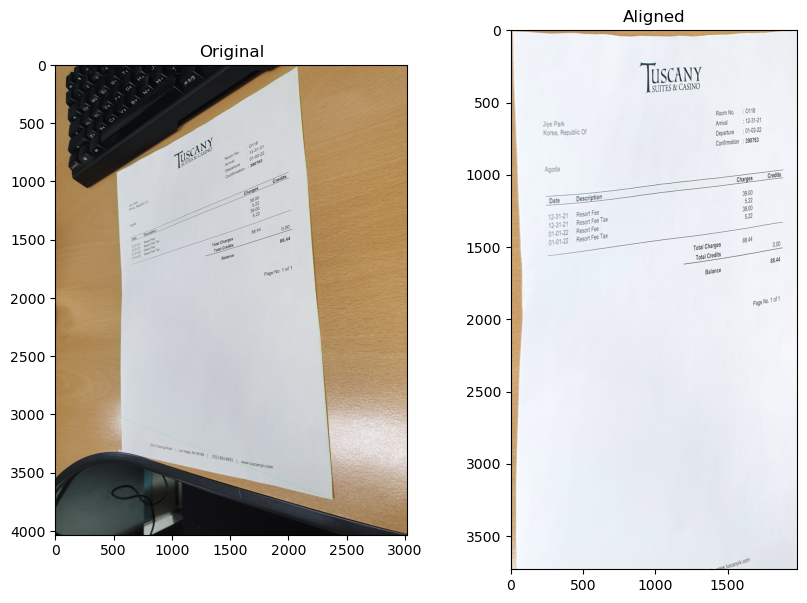

In [6]:
refFilename = "./temp_data/1.jpg"
image = cv2.imread(refFilename)

#1. Blur
blured_image = blur(image)

#2. Canny Edge detection
edges = cv2.Canny(blured_image, 50, 150, apertureSize=7)

# 3. Find Contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. Get largest contour (and crop)
biggest_n, approx_contour, contour_subset = biggest_contour(contours, min_area=image.size)

# 5. Crop Image
cropped_image = crop_image(image, contour_subset, biggest_n, approx_contour)

# 6. Sharpen and increase brightness
sharpened_image = sharpen_image(cropped_image)


f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_clean = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(im_clean)
axarr[1].title.set_text('Aligned')